<a href="https://colab.research.google.com/github/vanislekahuna/vanislekahuna.github.io/blob/test/notebooks/Bayesian_Simple_Linear_Regression_PyMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Playing with Fire and Priors: Learning the Limits of Bayesian Linear Regression with PyMC**




<img src="https://images.unsplash.com/photo-1686252180817-da1d0b72400c?q=80&w=870&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D" width=670 height=380>

[Source](https://unsplash.com/photos/a-close-up-of-a-rock-with-a-blurry-background-y4TCnzGshZQ?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash)

The precursor to all blazing wildfires in remote areas, such as forests or mountainsides, are three elements often referred to as the “fire triangle”: heat, fuel, and oxygen (BC Public Service, 2023). The “heat” represents the ignition source of the fire, such as a lightning strike or irresponsible human activity, while the “fuel” generally refers to organic matter that can keep the fire burning, such as dry grass, trees, or shrubs (BC Public Service, 2023). Oxygen, or more specifically wind speeds, is often what determines the rate of spread and which direction a fire is burning (BC Public Service, 2023).

<img src='https://www2.gov.bc.ca/assets/gov/public-safety-and-emergency-services/wildfire-status/wildfire-response/bcws-fire-triangle.png'>

Photo by [BC Wildfire Services](https://www2.gov.bc.ca/assets/gov/public-safety-and-emergency-services/wildfire-status/wildfire-response/bcws-fire-triangle.png)

Given the physical relationship between fires, fuel, and wind speeds, is it then reasonable to say that we can use one of these factors alone, such as wind speed, as a basis to make decisions, such as where to deploy emergency personnel? What we mean by this question is that if we, for example, knew in advance that a region would be expecting high winds during a summer period, would it be reasonable to expend resources and make decisions in that area in anticipation of a raging wildfire?

During the wildfire season, key decisions like these can often be the difference between life and death, forests burning, or properties being destroyed. For example, utility companies may have to make decisions on whether certain power lines need to be shut off during blustery days if there’s a significant risk of sparking a wildfire. Insurance companies might also be able to set fairer risk premiums if they can create better models for fire-prone areas or notify their portfolio properties during high-risk events. And then, of course, there are governments and fire management agencies that can take proactive approaches, such as planning evacuations or suppression tactics and proactively doing prescribed burns to reduce the risk of uncontrollable wildfires.

To find out whether we can use wind speeds alone as a reliable variable for predicting fire size (total hectares burnt in a wildfire), one strategy we utilize is a mathematical model you’ve likely touched on in high school - a Simple Linear Regression. A linear model like **Simple Linear Regression**, often described by the mathematical formula: $y = mx + b$, is great because it allows us to understand and predict the relationship between two variables, one being the **independent variable ($x$)** and the other known as the **dependent variable ($y$)**. In machine learning circles where we typically lurk in, these variables are also referred to as the **predictor variable ($x$)** and the **target variable ($y$)**, which we’ll stick to for the rest of this article. Given some data about these two variables, what a Simple Linear Regression does is generate a straight line that best fits through the scatterplot of the data, just like we have in *Figure 1*.

In [ ]:
%%capture
!pip install arviz==0.20.0
!pip install matplotlib==3.8.0
!pip install pandas==2.2.2
!pip install pymc==5.19.1
!pip install scipy==1.13.1

In [ ]:
import requests
import sqlite3
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import scipy.stats as stats

In [ ]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 824
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

/usr/local/lib/python3.12/dist-packages/arviz/rcparams.py:345: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


In [ ]:
size = 1000
y_intercept_b = 3
slope_m = 5

x = np.linspace(0, 1, size)

###########################################
### Simple Linear Regression: y = mx + b ##
###########################################
predicted_y = (slope_m * x) + y_intercept_b

# Adding noise
y = predicted_y + rng.normal(scale=1, size=size)

generated_data = pd.DataFrame({"x": x, "y": y})

In [ ]:
y_mean = np.mean(y)
ss_tot = np.sum((y - y_mean) ** 2)  # Total sum of squares
ss_res = np.sum((y - predicted_y) ** 2)  # Residual sum of squares
r_squared_manual = 1 - (ss_res / ss_tot)

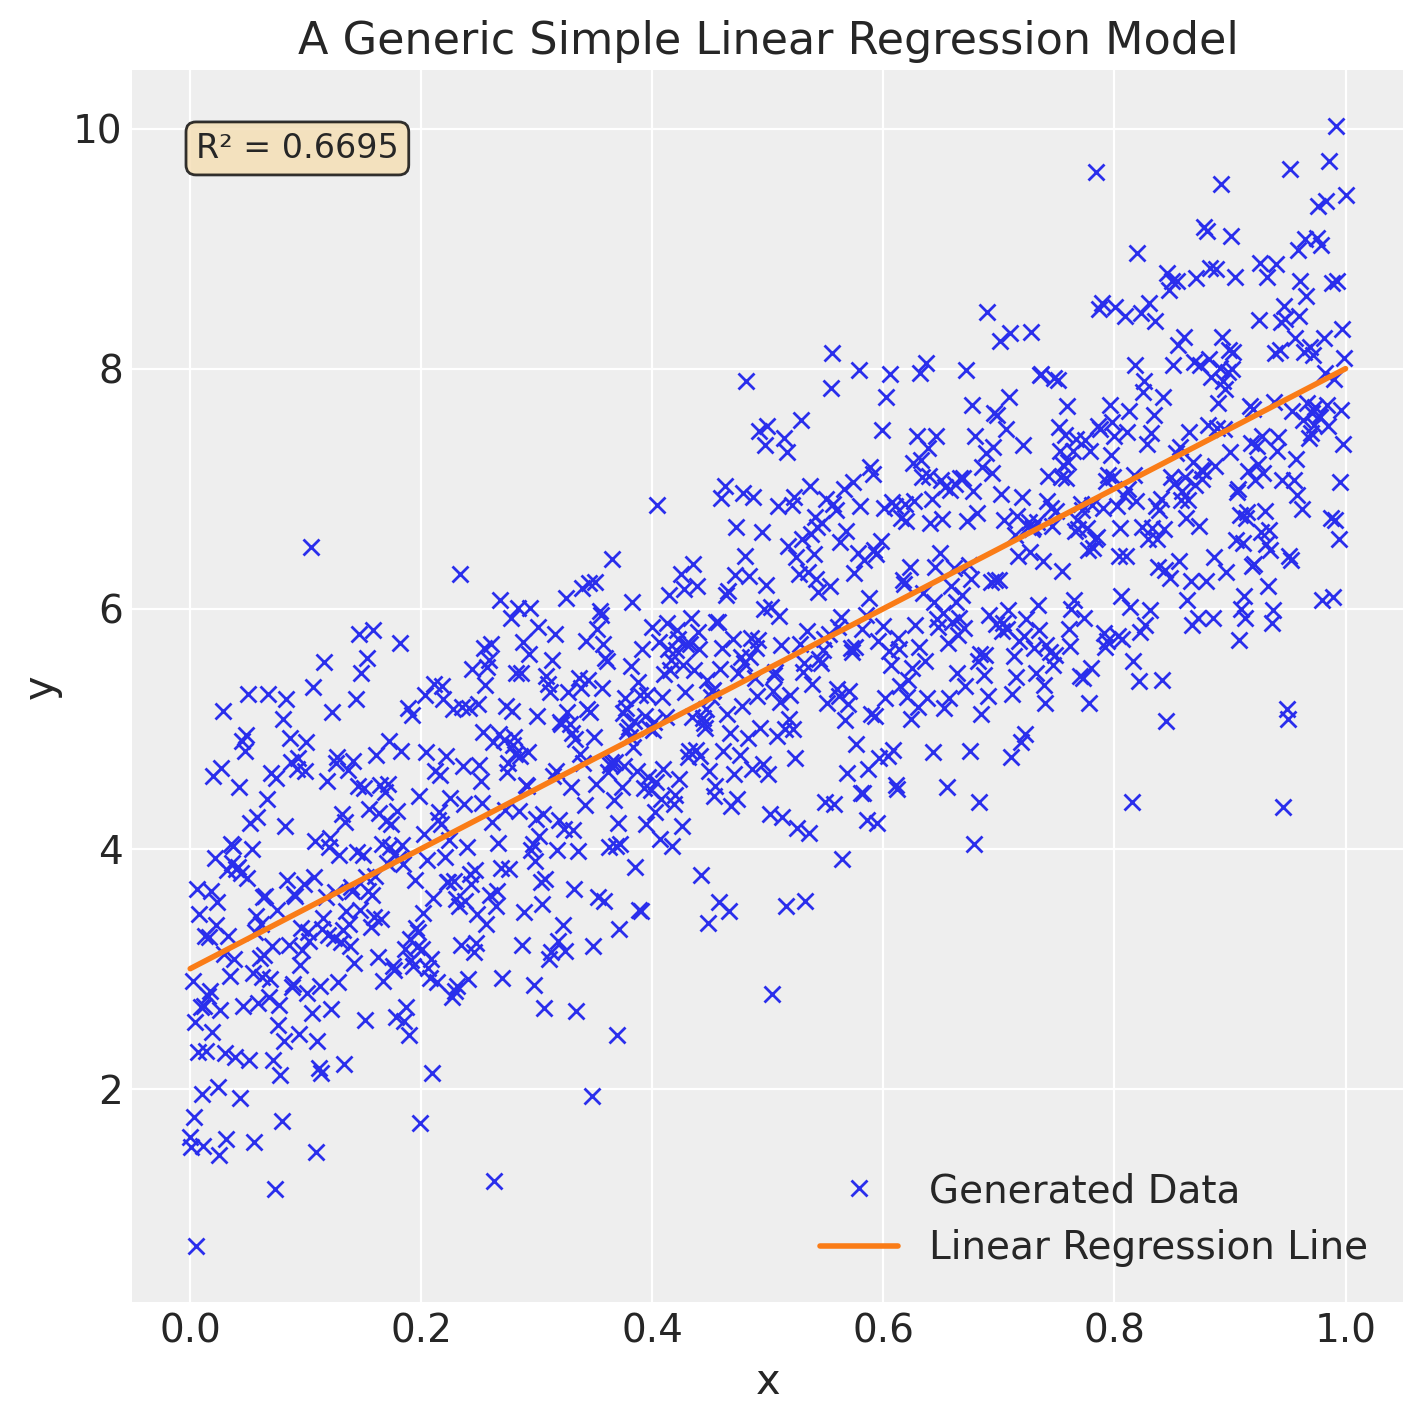

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="A Generic Simple Linear Regression Model")
ax.plot(x, y, "x", label="Generated Data")
ax.plot(x, predicted_y, label="Linear Regression Line", lw=2.0)
ax.text(0.05, 0.95, f'R² = {r_squared_manual:.4f}',
        transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.legend(loc='lower right')
plt.show()

Other details we should include about our simple linear regression model is the **slope ($m$)** which basically describes how much the target variable ($y$) changes with each unit increase of its predictor variable ($x$). Additionally, the **y-intercept ($b$)** is meant to describe what the value of the target variable ($y$) would be when the predictor variable ($x$) is $0$. For full details on how these values are calculated, we’ve provided the formula below:

<br>

\begin{align}
m &= \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^{n}(x_i - \bar{x})^2} \quad \\
b &= (m \times \bar{x}) - \bar{y} \\
y &= mx + b
\end{align}

<br>


<center><li><i>Note that $\bar{x}$ and $\bar{y}$ refers to the average $x$ and $y$ values</i></center>

Let’s review some key points on why regression models can be quite useful in understanding the relationship between two variables. The first is that regression models can help us understand the direction of the relationship - i.e. does $x$ increase with $y$, indicating a positive relationship? Or do we see $y$ consistently decrease as $x$ increases, indicating a negative relationship?

We can also determine the strength of the relationship between the two variables based on how close each of the points are to the regression line we generated. A metric like **R-squared ($R^2$)**, displayed on the top left of *Figure 1*, is often the best metric to measure the variance in the regression line and is represented by a value between 0 and 1. For the specifics, we can calculate $R^2$ using the following formula:

\begin{align}
SS_{Resid} &= \sum_{i=1}^{n}(y_i - \hat{y}_i)^2 \\
SS_{Total} &= \sum_{i=1}^{n}(y_i - \bar{y})^2 \\
R^2 &= 1 - \frac{SS_{Resid}}{SS_{Total}}
\end{align}

<br>

<center><li><i>Note that $\hat{y}$ refers to the predicted $y$ value</i></center>

Lastly, because linear regressions can model the strength and relationship between two variables, we can use it to make predictions on data outside of our dataset, given we have data on our predictor variable ($x$).

Great! Now that we’ve had the chance to review the basics of Linear Regression, let’s level up our understanding by adding the Bayesian interpretation of this concept. In a [previous article](https://pub.towardsai.net/why-most-introductory-examples-of-bayesian-statistics-misrepresent-it-d2e12ac69278), we wrote about how Bayesian methods distinguish themselves as a separate branch of statistics owing to the fact that it *considers the full range of possible outcomes in the form of probability distributions* to model relationships. So when building a linear regression model to determine whether wind speeds predict fire size, a Bayesian model would consider every combination of our parameter values - slope ($m$) and y-intercept ($b$). Through our parameter values, we can apply a key principle of Bayesian Statistics, which is to incorporate our **prior beliefs** on what these probability distributions might be. In other words, what information about wind speed or fire size do we already know based on our understanding of the natural world that we can then encode in a probability distribution for our model?

By incorporating the full range of possibilities in our model, we’re then able to quantify the model’s uncertainty in its predictions, which wouldn’t have been possible if we had only generated a single regression line. Instead, we can test all plausible combinations of parameter values against our collected data to produce a posterior distribution *for each individual mean predictor value*, which effectively generates hundreds (or thousands, depending on the dataset size) of regression lines, thus giving us a fuller understanding of the relationship between wind speed and fire size.

Another key aspect of Bayesian Linear Models is that they are especially useful in circumstances where we have access to limited data, although this isn’t a challenge we’re currently constrained with. Since we’re able to encode our hypothesis on the relationship between our predictor and target variable, our prior knowledge can make up for the lack of data. As we continue to fit our Bayesian model on new data, theoretically, over time, the model updates itself to better model the relationship.
Now that we’ve reviewed the basics for Linear Regression and Bayesian Inference, here’s the game plan for modelling a potential relationship between our two variables:

Extract our dataset;

1. Clean our data;
2. Do exploratory data analysis;
3. Formalize our Bayesian Linear Regression model;
4. Simulate our priors;
5. Generate a posterior distribution;
6. Evaluate our results.

## Data Extraction

During the [data science workflow](https://github.com/vanislekahuna/Portfolio-Projects/blob/main/Mankinds-Evolution_The-need-for-TSL-in-the-Age-of-AI_Trinity-Western-MA-in-Leadership-LIP-Thesis_Ruiz-Rivera_eBook.pdf), before any modelling takes place, we must first procure our data. Thanks to the folks at [BC Wildfire Services](https://catalogue.data.gov.bc.ca/dataset/bc-wildfire-fire-incident-locations-historical), who provided an open-source dataset on historical wildfires in BC, we were able to combine it with satellite weather data from Google Earth Engine. In case you're interested, [we documented the specifics](https://medium.com/towards-artificial-intelligence/how-to-augment-wildfire-datasets-with-historical-weather-data-using-python-and-google-earth-engine-eae4c2a73650) of how we engineered this dataset if you'd like to re-create our work.

In terms of tooling to fit our historical wildfire data to the Bayesian workflow, in our opinion, the best package for the job is PyMC due to its syntax closely resembling the **applied statistical model notation** that we discussed in a [previous article](https://medium.com/towards-artificial-intelligence/an-intro-to-pymc-and-the-language-for-describing-statistical-models-ac9d56c363c0). Besides the computational benefits that come with the package, PyMC makes it intuitive to translate the conceptual model notations that statisticians utilize into code within the well-established Python ecosystem.

We'll also use the `sqlite3` package to extract the dataset we engineered from Google Earth Engine and then later stored as a database file in our GitHub repo:

In [ ]:
db_link = "https://raw.githubusercontent.com/vanislekahuna/wps-labs/main/data/historical_bc_wildfires/bc_wildfires.db"
response = requests.get(db_link)
with open("bc_wildfires.db", "wb") as f:
    f.write(response.content)

conn = sqlite3.connect('bc_wildfires.db')
cursor = conn.cursor()

In [ ]:
join_query = """
WITH weather AS (
    SELECT *
    FROM weather_data
)
SELECT *
FROM historical_bc_wildfires AS historical
LEFT JOIN weather ON historical.FIRELABEL = weather.fire_label
WHERE historical.SIZE_HA IS NOT NULL
AND historical.SIZE_HA > 0;
"""
# AND historical.FIRELABEL NOT IN ('1951-R00037', '1951-R00050', '1951-R00060', '1951-R00067', '1951-R00069', '1951-R00070', '1956-R00107', '1958-V00283', '1956-R00160', '1968-R00088', '1985-V70083', '1985-V70088', '1987-V90016', '1990-V50012');


df = pd.read_sql_query(join_query, conn)

print(f'DataFrame shape: {df.shape} \n\n \
Columns: {df.columns}')

df.head()

DataFrame shape: (162919, 29) 

 Columns: Index(['FIRE_NO', 'FIRE_YEAR', 'RSPNS_TYPC', 'IGN_DATE', 'FR_T_DTE',
       'FIRE_CAUSE', 'FIRELABEL', 'FRCNTR', 'ZONE', 'FIRE_ID', 'FIRE_TYPE',
       'INCDNT_NM', 'GEO_DESC', 'LATITUDE', 'LONGITUDE', 'SIZE_HA', 'FCODE',
       'SHAPE', 'OBJECTID', 'X_COORDINATE', 'Y_COORDINATE', 'temperature_c',
       'wind_speed_ms', 'wind_direction_deg', 'wind_direction',
       'humidity_dewpoint_temperature_2m', 'soil_temperature_level_1',
       'fire_label', 'ignition_datetime'],
      dtype='object')


,FIRE_NO,FIRE_YEAR,RSPNS_TYPC,IGN_DATE,FR_T_DTE,FIRE_CAUSE,FIRELABEL,FRCNTR,ZONE,FIRE_ID,...,X_COORDINATE,Y_COORDINATE,temperature_c,wind_speed_ms,wind_direction_deg,wind_direction,humidity_dewpoint_temperature_2m,soil_temperature_level_1,fire_label,ignition_datetime
0,V11082,2021,Full,2.021063e+13,2.021063e+13,Person,2021-V11082,2.0,1.0,1082,...,1.389403e+06,468420.7493,24.190454,0.238463,320.277699,Northwest,288.407013,293.928192,2021-V11082,2021-06-30 16:15:22
1,K50948,2020,Full,2.020080e+13,2.020081e+13,Person,2020-K50948,5.0,5.0,500948,...,1.450366e+06,552207.4119,26.581812,0.702857,77.036522,East,279.547333,296.103882,2020-K50948,2020-08-04 22:30:00
2,V70735,2021,Full,2.021061e+13,2.021061e+13,Person,2021-V70735,2.0,7.0,735,...,1.150998e+06,457333.8431,14.023950,3.984139,281.921492,West,278.705872,288.122131,2021-V70735,2021-06-05 22:51:26
3,K20928,2021,Full,2.021063e+13,2.021063e+13,Person,2021-K20928,5.0,2.0,928,...,1.384145e+06,620763.7097,16.139764,2.504193,296.359838,Northwest,282.903931,288.909363,2021-K20928,2021-06-26 11:47:31
4,V81001,2022,Full,2.022080e+13,2.022080e+13,Person,2022-V81001,2.0,8.0,1001,...,1.003721e+06,584234.2772,13.016840,2.674716,303.074576,Northwest,282.843109,288.308258,2022-V81001,2022-08-02 04:30:37


## Data Cleaning: Utilizing Functions

We'll also be sure to do some light cleaning to remove any null values from the target variable:

In [ ]:
dropped_df = df.copy()
dropped_df.dropna(subset=["SIZE_HA"], inplace=True)

wildfire_df = dropped_df[dropped_df["SIZE_HA"] > 0].sort_values("ignition_datetime", ascending=True)
print(f'Average wind speed: {round(wildfire_df["wind_speed_ms"].mean(), 2)} metres per second (mps)')

wildfire_df.head()

Average wind speed: 1.52 metres per second (mps)


,FIRE_NO,FIRE_YEAR,RSPNS_TYPC,IGN_DATE,FR_T_DTE,FIRE_CAUSE,FIRELABEL,FRCNTR,ZONE,FIRE_ID,...,X_COORDINATE,Y_COORDINATE,temperature_c,wind_speed_ms,wind_direction_deg,wind_direction,humidity_dewpoint_temperature_2m,soil_temperature_level_1,fire_label,ignition_datetime
68056,C00112,1958,None,19580526.0,1.958053e+13,Person,1958-C00112,7.0,0.0,7000112,...,1.275939e+06,696519.3824,NaN,NaN,NaN,No data returned,NaN,NaN,1958-C00112,1958-05-26 00:00:00
73288,K00172,1958,None,19580526.0,1.958053e+13,Person,1958-K00172,5.0,0.0,5000172,...,1.407932e+06,714172.7407,NaN,NaN,NaN,No data returned,NaN,NaN,1958-K00172,1958-05-26 00:00:00
67690,C00002,1958,None,19580526.0,1.958053e+13,Person,1958-C00002,7.0,0.0,7000002,...,1.061199e+06,884292.7772,NaN,NaN,NaN,No data returned,NaN,NaN,1958-C00002,1958-05-26 00:00:00
68723,C00024,1958,None,19580526.0,1.958053e+07,Unknown,1958-C00024,7.0,0.0,7000024,...,1.294959e+06,908051.8788,NaN,NaN,NaN,No data returned,NaN,NaN,1958-C00024,1958-05-26 00:00:00
67443,C00106,1958,None,19580526.0,1.958053e+07,Person,1958-C00106,7.0,0.0,7000106,...,1.308504e+06,682266.8927,NaN,NaN,NaN,No data returned,NaN,NaN,1958-C00106,1958-05-26 00:00:00


In [ ]:
print(f'Average fire size: {round(wildfire_df["SIZE_HA"].mean(), 2)} hectares burnt')

Average fire size: 83.95 hectares burnt


Next, we’ll call upon some functions we’ve created or adapted from other projects:

In [ ]:
def plot_histogram(serie, xtit='Wind Speed (m/s)', ytit='Frequency', tit='Distribution of Wind Speed', kde_plot=True):
    """
    Plots a histogram of a pandas Series, with an optional Kernel Density Estimate (KDE) plot.

    The function first cleans the input Series by dropping missing and infinite values. It then
    generates and displays a histogram using either matplotlib's hist function combined with
    seaborn's kdeplot, or seaborn's displot.

    Parameters
    ----------
    serie : pandas.Series
        The data to be plotted.
    xtit : str, optional
        The title for the x-axis. Defaults to 'Wind Speed (m/s)'.
    ytit : str, optional
        The title for the y-axis. Defaults to 'Frequency'.
    tit : str, optional
        The title for the plot. Defaults to 'Distribution of Wind Speed'.
    kde_plot : bool, optional
        If True, plots a histogram using `plt.hist` and a KDE using `sns.kdeplot`.
        If False, plots the histogram and KDE using `sns.displot`. Defaults to True.

    Returns
    -------
    None
        This function does not return any value; it displays the plot directly.

    Notes
    -----
    - The function will drop all `NaN` and infinite values from the input `serie`
      before generating the plot.
    - The `kde_plot` parameter controls the plotting method.
      - When `kde_plot=True`, `plt.hist` and `sns.kdeplot` are used.
      - When `kde_plot=False`, `sns.displot` with `kde=True` is used.
    - This function requires `matplotlib.pyplot` and `seaborn` to be imported.
    """

    serie = serie.dropna() # Remove missing values
    serie = serie[np.isfinite(serie)] # Remove infinite values
    plt.figure(figsize=(10, 6))

    if kde_plot==True:
      plt.hist(serie, bins=30, alpha=0.7, density=True, color='royalblue', edgecolor='black')
      sns.kdeplot(serie, color='violet', linewidth=2)

    else:
      sns.displot(serie, kind='hist', kde=True, height=6, aspect=1.5)

    plt.xlabel(xtit)
    plt.ylabel(ytit)
    plt.title(tit)
    plt.grid(alpha=0.3)
    plt.show()

In [ ]:
def link(pymc_trace, val_range=list, x_col=None, y_col=None, dataset=None, hdi=False, hdi_ci=0.89, prior_1=str, prior_2=str):
    """
    Generate predictive distributions based on a PyMC trace and specified variables.

    This function extracts a dataset from a provided PyMC trace and calculates the predictive
    distribution of a response variable based on two prior variables. The predictive mean is computed
    for a range of input values, and if specified, a highest density interval (HDI) is also calculated
    for these predictions.

    Parameters:
    ----------
    pymc_trace : pymc3.trace
        A trace object obtained from a PyMC model, containing posterior samples.

    val_range : list
        A list of input values over which to evaluate the predictive distribution. Default is an empty list.

    x_col : array-like, optional
        The predictor variable corresponding to the input values. If not provided, the mean of the column is used.

    y_col : array-like, optional
        The response variable. This parameter is not used in the current implementation but can be included for future expansion.

    dataset : pd.DataFrame, optional
        The original dataset used for modeling. This parameter is not used in the current implementation but can be included for future expansion.

    hdi : bool, optional
        If True, the function computes the highest density interval (HDI) for the predictive distributions. Default is False.

    hdi_ci : float, optional
        The credibility interval for the HDI, expressed as a proportion (e.g., 0.89 for 89% CI). Default is 0.89.

    prior_1 : str
        The name of the first prior variable in the trace to be used for calculation.

    prior_2 : str
        The name of the second prior variable in the trace to be used for calculation.

    Returns:
    -------
    mu_pred_link : np.ndarray
        An array of predicted values corresponding to the input values in `val_range`.
        If `hdi` is True, the function also prints compatibility intervals for user-selected input values.
    """

    trace_N = az.extract_dataset(pymc_trace)
    n_samples = trace_N.sizes["sample"]
    mu_pred_link = np.zeros((len(val_range), n_samples))

    for i, w in enumerate(val_range):
      mu_pred_link[i] = trace_N[prior_1] + trace_N[prior_2] * (w - x_col.mean())

    if hdi is True:
      hdi_array = []
      for each_row in mu_pred_link:
        ci = az.hdi(each_row, hdi_prod=hdi_ci)
        hdi_array.append(ci)

      while True:
        print(f"Input a row number between 0 and {mu_pred_link.shape[0] - 1} to display its compatibility interval: ")
        number = int(input())
        try:
          row_n = int(number)
          if row_n < mu_pred_link.shape[0]:
            print("\n")
            print(f"The distribution of values calculated for the input variable ({val_range[row_n]:.2f}) on row {row_n} are the following: \n {mu_pred_link[row_n]} \n")
            print(f"{(hdi_ci * 100):.0f}% of the plausible values in the distribution calculated from the input {val_range[row_n]:.2f} fall between {hdi_array[row_n][0]:.2f} and {hdi_array[row_n][1]:.2f}. \n")
            return mu_pred_link
            break
          else:
            print(f"The value is larger than the size of the dataset used to train the model. \
            Please input a value that is less than {mu_pred_link.shape[0]}.")
        except ValueError:
          print("Invalid input. Please enter a valid integer.")

    else:
      return mu_pred_link

## Exploratory Data Analysis

Now that we have our data in rotation, let's visualize our main variables to better understand their structure:

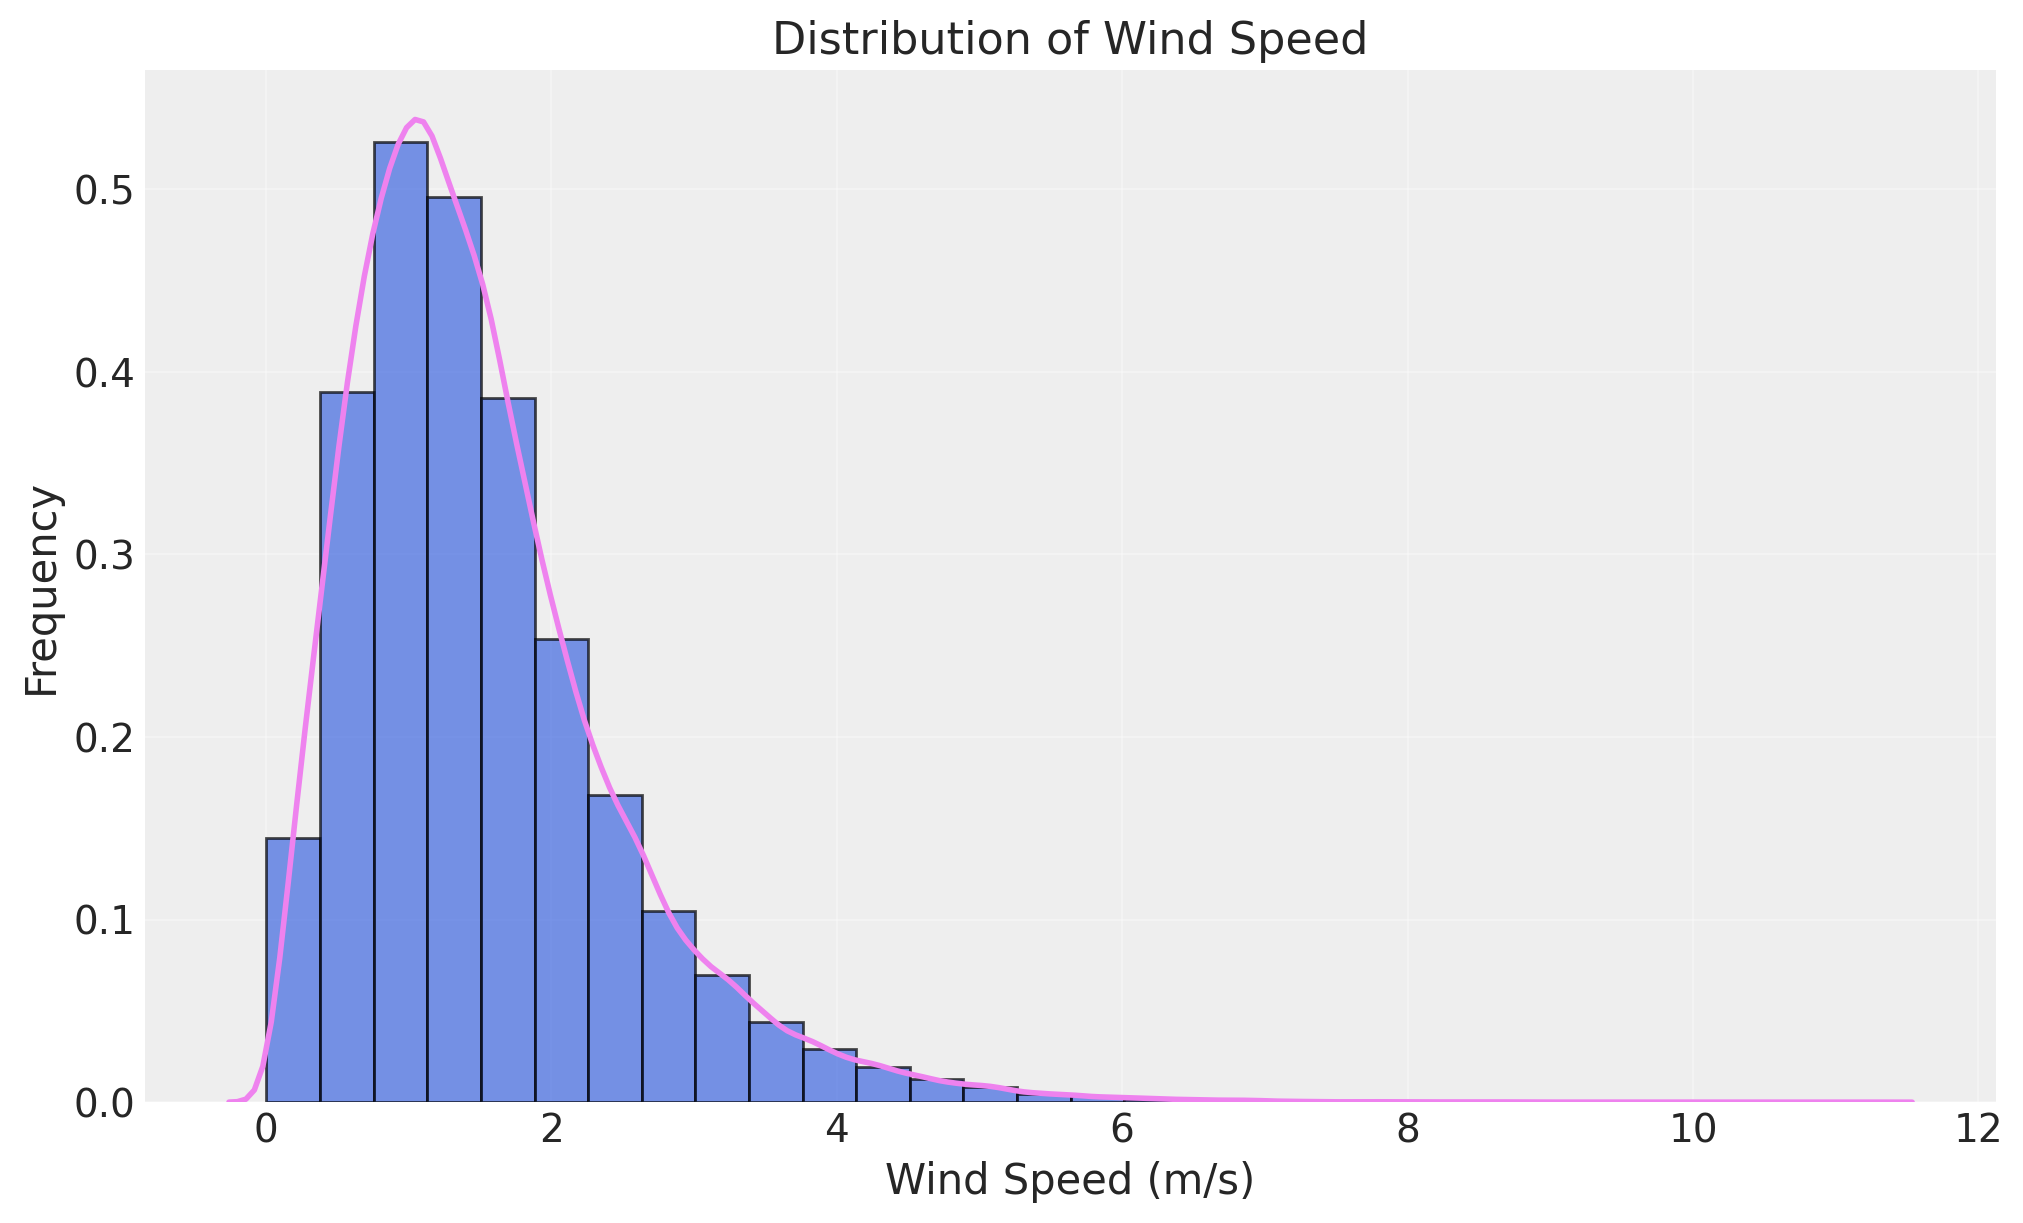

In [ ]:
plot_histogram(wildfire_df['wind_speed_ms'], kde_plot=True)

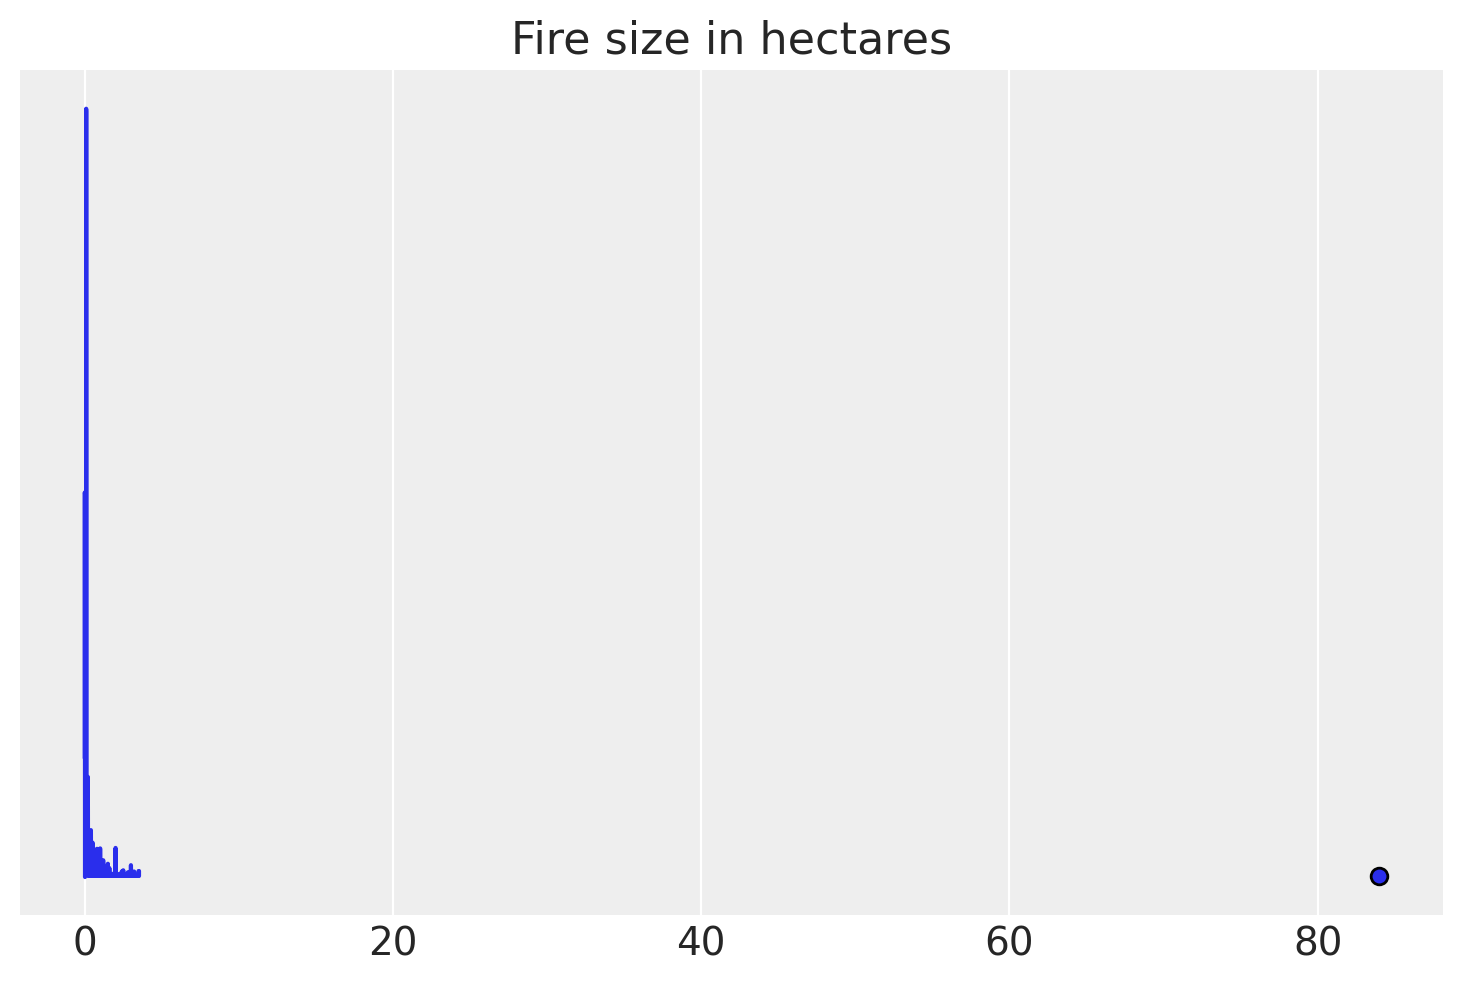

In [ ]:
size_ha = wildfire_df["SIZE_HA"].to_numpy()
az.plot_density(size_ha)
plt.title("Fire size in hectares")
plt.show()

From the jump, we can see that both our wind speed (measured in metres per second) and our fire size data (measured in hectares burnt) display characteristics of a right-skew distribution where the majority of data points are clustered on the lower ends of the distribution. This is especially prevalent with our target variable, fire size, where the majority of data points are clustered near zero, indicating that the vast majority of fires are luckily very small!

## Formalizing our Bayesian Linear Regression Model

Formalize our Bayesian Linear Regression Model
Given what we know about our data and how wildfires work in the real world, let’s take a stab at formalizing our model using statistical model notation to communicate the prior assumptions we’ll be embedding into our model:

\begin{align}
\log(FireSize_i + 1) &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta \cdot x_i \\
x_i &= \log(WindSpeed_i + 1) \\
\alpha &\sim \text{Normal}(4, 0.5) \\
\beta &\sim \text{HalfNormal}(0, 0.3) \\
\sigma &\sim \text{HalfNormal}(0, 0.5)
\end{align}

$Where$:

- $FireSize_i$ represents our target variable from the `wildfire_df['SIZE_HA']` column of our dataset;
- $WindSpeed_i$ represents our predictor variable from the `wildfire_df['wind_speed_ms']` column of our dataset;
- $\mu_i$ is an individual value for the size of a fire, represented in hectares;
- $\alpha$ is equivalent to a linear regression's y-intercept;
- $\beta$ is equivalent to a linear regression's slope;
- $\sigma$ is the distribution of the standard deviation.

With the scaffolding in place, let’s review how to read each line of our model notation. Line 1 can be read as “the logarithm (with 1 added to remove mathematical issues with zeroes) of the total spread of each individual fire ($i$) in our dataset is distributed as (this is what the $\sim$ symbol indicates) a normal, or bell-curved, distribution based on its mean and standard deviation value.

The mean value associated with each individual fire can be calculated deterministically ($=$) in Line 2 through the traditional Ordinary Least Squares (OLS) Linear Regression formula we reviewed earlier, with our alpha (α) parameter representing the y-intercept and the beta (β) parameter representing the slope.

Similar to the log transformation we did in Line 1, we use Line 3 to define our predictor value ($x_i$) as the log-transformed wind speed, where we add 1 before taking the logarithm to handle cases where wind speed might be zero (since `log(0)` is undefined).

Lines 4-6 are meant to encode our prior beliefs or initial hypotheses about the unobserved parameters. In Line 4, our α (the y-intercept) parameter is normally distributed ($\sim$) around 4, representing our baseline expectation for log fire size.

However, in Lines 5 & 6, we break from conventional Gaussian distributions by using Half-Normal distributions that only allow for positive values. By selecting Half-Normal distributions, we can embed our model with our prior knowledge of the natural world, where we know that higher wind speeds always increase fire spread (never decrease it), so therefore our uncertainty parameter (σ) must also be positive by definition. This choice prevents our model from learning impossible relationships, like wind somehow reducing fire size. Our slope parameter (β) averages are near 0 but can only be positive, meaning we expect wind to have some positive effect on fire size. Additionally, our standard deviation (σ) parameter represents the natural variability in our predictions and stays small and positive.

You might be asking why we decided to do a log-transformation of our predictor and target variables rather than using the raw data? The reason for this was to address the skew of both our variables and transform them on a logarithmic scale in an attempt to normalize the distributions. Multiplying a set of numbers on a log scale is a common practice when dealing with large deviations in a distribution, as the transformation then results in a Gaussian distribution (McElreath, 2020). If you are interested in understanding how logarithmic scales work, we suggest checking out our notes on the math behind this data transformation to gain a deeper understanding of the process.

However, we should point out that there is a downside to this approach of having to do log-transformations on both variables due to their extremely right-skewed characteristics. This extreme skew may come back to bite us later when we generate and plot the model’s posterior inference against the data, but we’ll get into that topic later on.

## Prior Predictive Simulation

Now that our Bayesian Linear Regression model is explicitly defined, what we’d want to do next is to run a process called **prior predictive simulation**, where we simulate the values that we should expect to see from the priors we’ve chosen. The purpose of this simulation is to generate samples from the specified prior distributions, thereby simulating the distribution of wildfire spread. Prior predictive simulations are like asking a model to make predictions about the target variable *before* seeing the data in an effort to ensure that the priors we’ve chosen actually make sense. Now enough talking, let’s have a peek at our prior distribution:

Text(0.5, 1.0, 'Sigma (st dev) ~ HalfNormal(0, 0.5)')

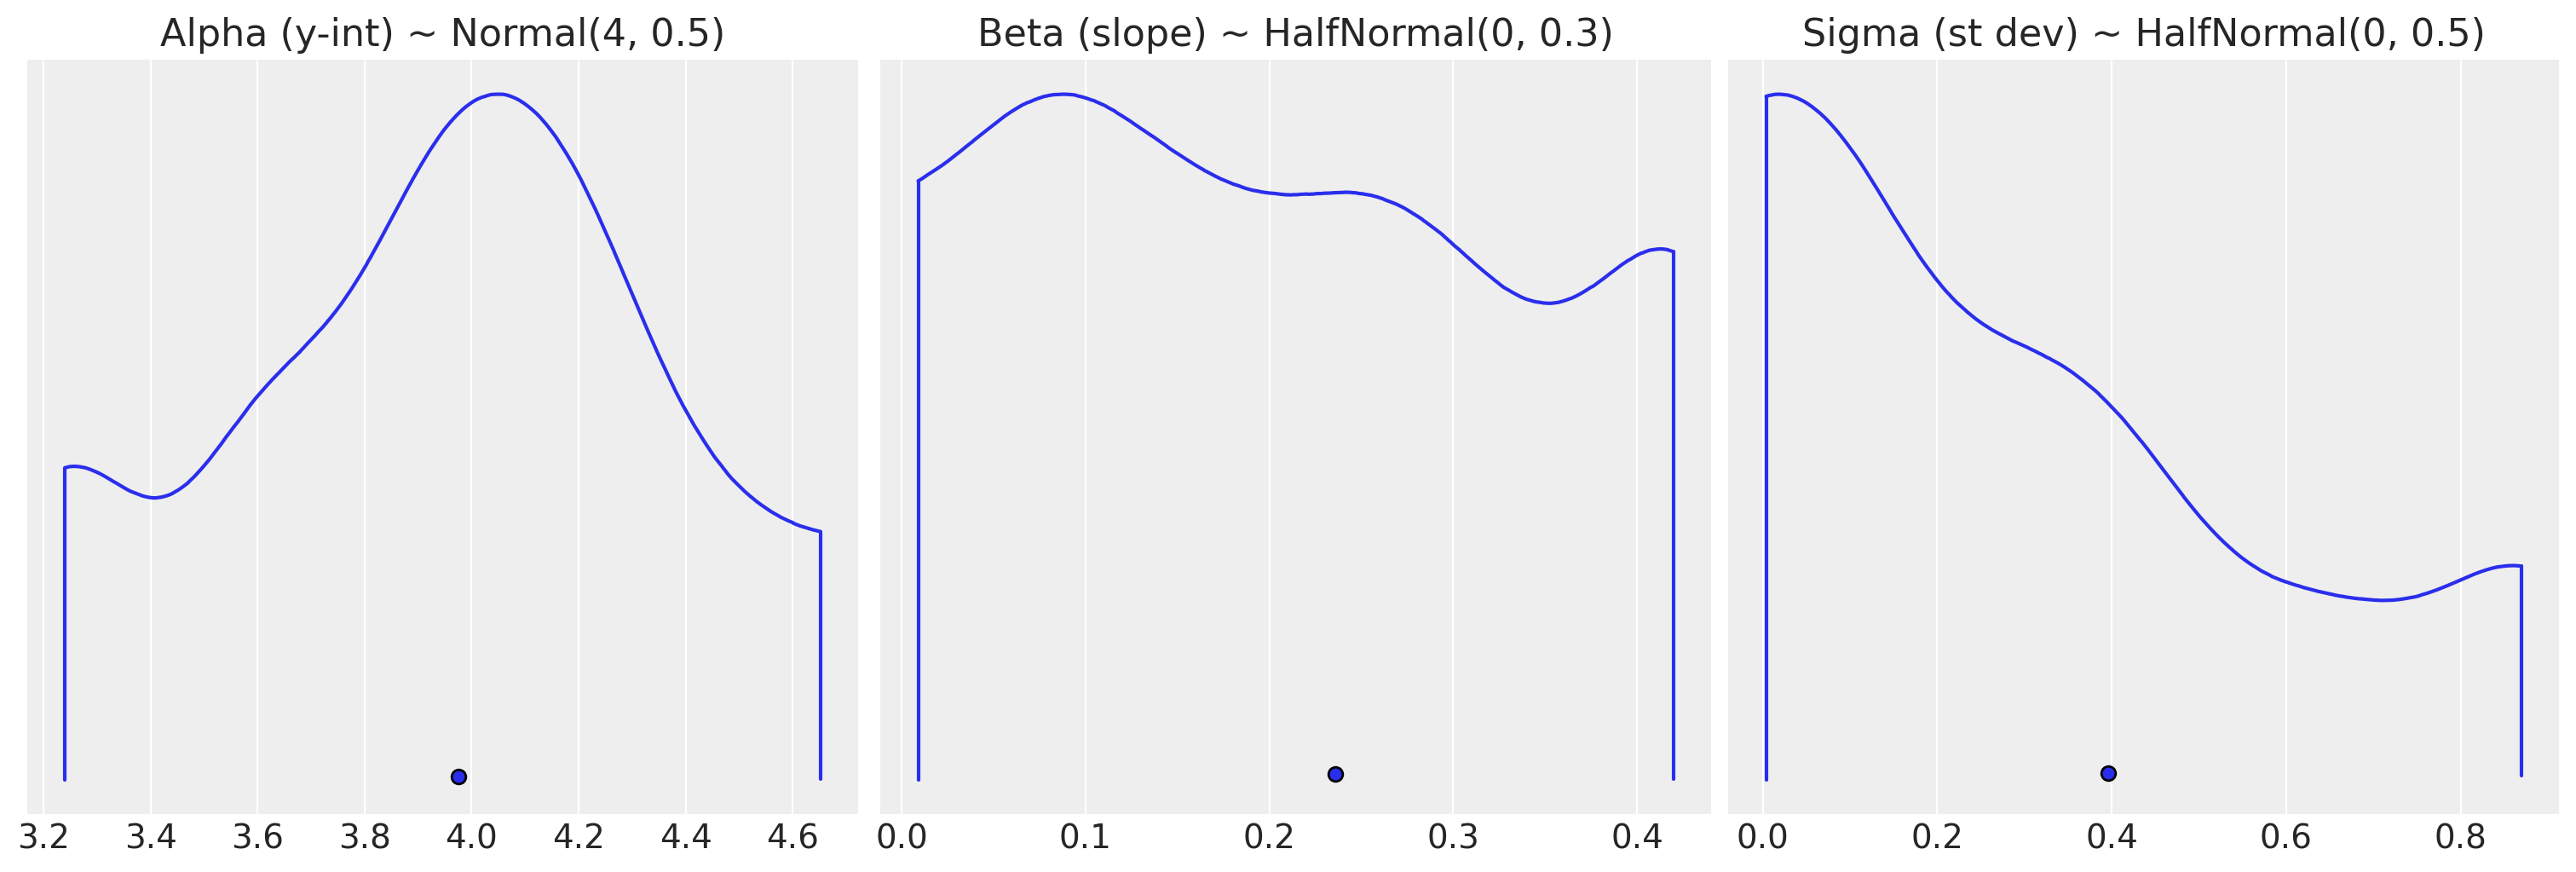

In [ ]:
fig, ax = plt.subplots(1, 3, sharey=False, figsize=(15, 5))
N = 100

y_int_alpha = stats.norm.rvs(loc=4, scale=0.5, size=N)
az.plot_density(y_int_alpha, group="prior", ax=ax[0])
ax[0].set_title("Alpha (y-int) ~ Normal(4, 0.5)")

slope_beta = stats.halfnorm.rvs(loc=0, scale=0.3, size=N)
az.plot_density(slope_beta, group="prior", ax=ax[1])
ax[1].set_title("Beta (slope) ~ HalfNormal(0, 0.3)")

stdev_sigma = stats.halfnorm.rvs(scale=0.5, size=N)
az.plot_density(stdev_sigma, group="prior", ax=ax[2])
ax[2].set_title("Sigma (st dev) ~ HalfNormal(0, 0.5)")

As expected, our distributions overall are relatively tight, which seems reasonable when working with log-transformed data. Our priors are moderately informative which means that they provide reasonable constraints without being overly restrictive. The model expects wind speeds to have a positive effect on fire size (i.e. more wind roughly equals more fire spread) without being overly confident in those initial assumptions. Additionally, our priors prevent unrealistic scenarios where the model might conclude that wind speeds have a negative effect on fire size (i.e. less wind equalling more fire spread).

Given we’ve now simulated values of the priors we formalized for our slope and y-intercept, let’s plug each of them into the simple linear regression equation we defined in Line 2 of our model to see what type of regression lines they will generate:

Text(0.5, 1.0, 'Prior Predictive Simulations of the parameter \n values in our Bayesian Linear Regression model \n')

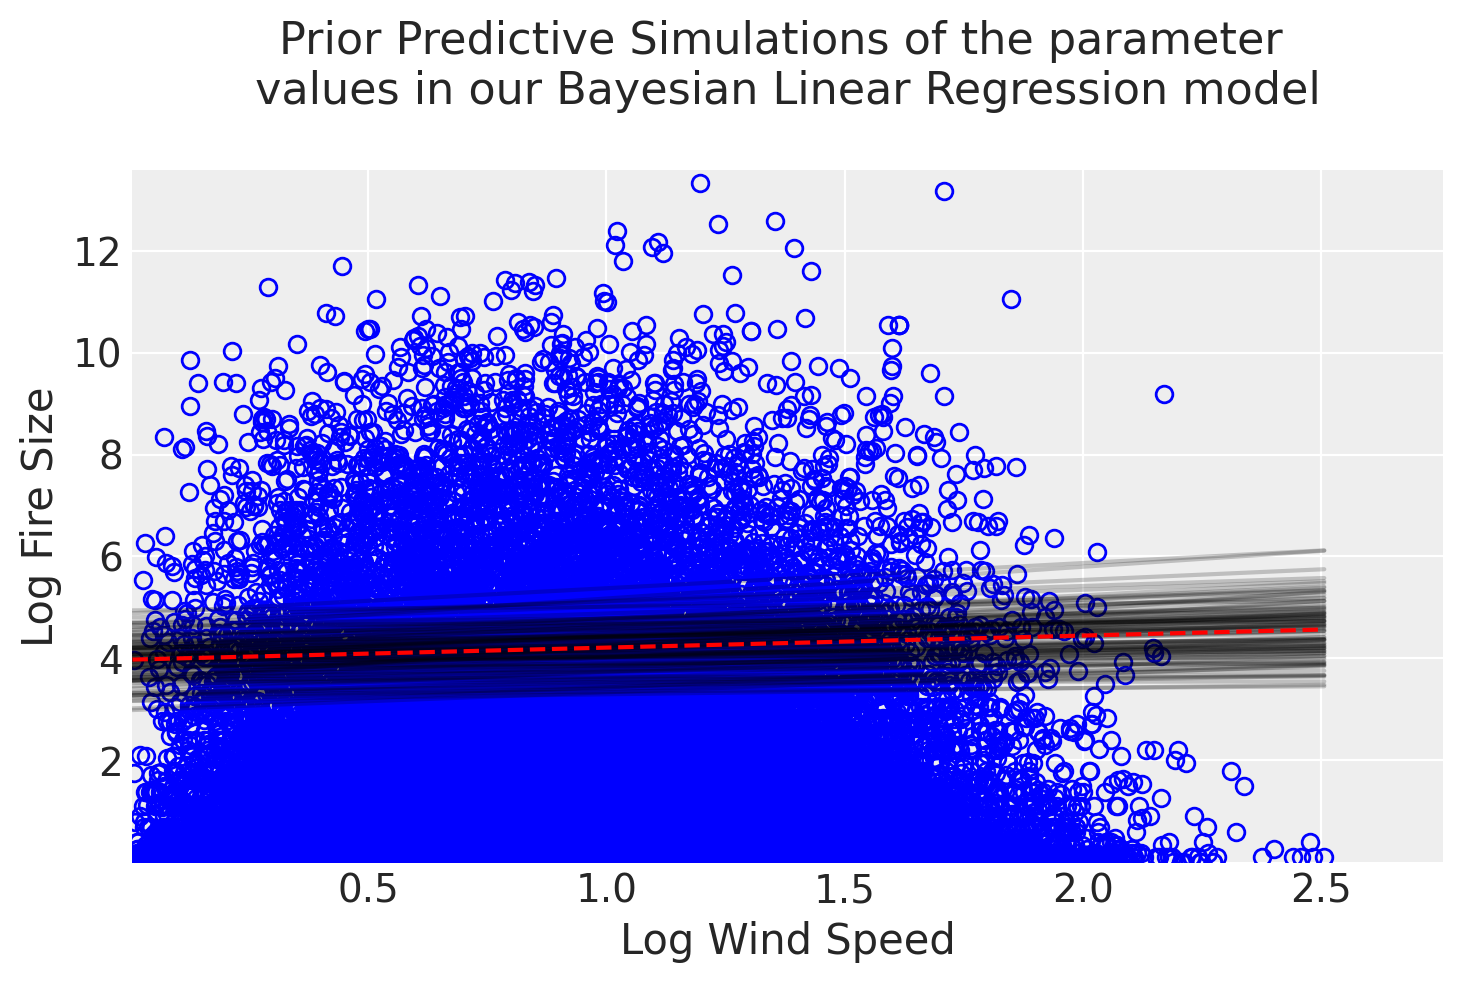

In [ ]:
N = 100
wind_speed_predictor = np.log1p(wildfire_df['wind_speed_ms'])
fire_size_target = np.log1p(wildfire_df['SIZE_HA'])

x_simple = np.linspace(wind_speed_predictor.min(), wind_speed_predictor.max(), N)
xbar = wind_speed_predictor.mean()

# 1. Generates a scatter plot of our log-transformed variables.
plt.plot(wind_speed_predictor, fire_size_target, marker="o", color="none", markeredgecolor="blue")

# 2. Plots grey regression lines from each of the N values sampled in the slope & y-int parameter.
for i in range(N):
  regression_distribution = y_int_alpha[i] + slope_beta[i] * x_simple
  plt.plot(x_simple, regression_distribution, "k", alpha=0.2)

# 3. Plots the mean Linear Regression line of the sampled values in red.
linear_reg = []
for i in range(N):
  regression = y_int_alpha.mean() + slope_beta.mean() * x_simple[i]
  linear_reg.append(regression)
plt.plot(x_simple, linear_reg, linestyle='--', color='red')

# 4. Formats the rest of the graph.
plt.xlim(wind_speed_predictor.min(), wind_speed_predictor.max() + 0.25)
plt.ylim(fire_size_target.min(), fire_size_target.max() + 0.25)
plt.ylabel("Log Fire Size")
plt.xlabel("Log Wind Speed")
plt.title("Prior Predictive Simulations of the parameter \n \
values in our Bayesian Linear Regression model \n")

It looks like our simulated Linear Regression lines seem to have reasonable estimates of the relationship between the predictor and target variable. The cloud of grey regression lines represents the model’s **uncertainty** with its simulated prior distributions, while the red dotted line just represents the average values of those distributions. One thing we could note with our prior simulation is that the slope of the regression lines is mostly flat, which reflects our hypothesis where we estimate that wind speeds have a conservative effect on fire size. From the graph, we can also observe that the model consistently displays high uncertainty throughout the regression line due to the cloud’s loose fit along the regression line which may play a role in the model’s predictive power.

## Fitting the Model

Since our prior predictive simulation suggests that the priors we’ve chosen are sensible, we can now fit our model to our historical wildfire data to generate a posterior distribution of the model’s parameters that quantify the uncertainty in the relationship. But before we can actualize our model in PyMC, we should first say a few words about the sampling methods used to actually generate a posterior distribution.

Intuitively, the first process that probably comes to mind in terms of how we’ll sample our model is what’s called the brute force method, also known as grid approximation. With grid approximation, what we’re doing is generating our posterior distribution by plugging in every combination of parameter values (α & β) into our model along with our observed wildfire data ($x_i$). So, for example, if we took a small 100 samples of our y-intercept (α) parameter and 100 samples of our slope (β) parameter, already our grid of possible linear models would result in 10,000 total combinations (100 × 100 = 10,000). However, generating a posterior distribution this way is generally NOT RECOMMENDED due to its computational load, especially as you increase the size of your sample and/or the number of parameters in your model. Having said that, the default sampling algorithm for [PyMC](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html) is the **Markov Chain Monte Carlo (MCMC)** method, which we’ll gloss over for now as we’ll be exploring it in more depth in a future article.

Let’s now translate our applied statistical model notation to Python code to evaluate how it held up against our data:

In [ ]:
wind_speed_ms = np.where(np.isfinite(wind_speed_predictor), wind_speed_predictor, 0)
xbar = wind_speed_predictor.mean()
print(f"Average log-transformed wind speed: {xbar} \n")

with pm.Model() as linear_reg_model:
    a = pm.Normal("a", mu=4, sigma=0.5)
    b = pm.HalfNormal("b", sigma=0.3)
    sigma = pm.HalfNormal("sigma", sigma=0.5)
    mu = a + b * wind_speed_ms
    size_logTransform = pm.Normal("size", mu=mu, sigma=sigma, observed=fire_size_target.values)
    linear_reg_model_trace = pm.sample(1000, tune=1000)

Average log-transformed wind speed: 0.8608978762078189 



Output()

## Model Evaluation

Now that we’ve computed our posterior distribution, we have a couple of options available to us to evaluate our results. The first is to simply generate a summary table of the **marginal posterior distributions** of the parameters which characterize the MCMC approximation for each of the parameter values (α, β, and σ):

In [ ]:
az.summary(linear_reg_model_trace, kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.489,0.007,0.477,0.500
b,0.096,0.008,0.084,0.109
sigma,1.254,0.002,1.251,1.258


From the table, we can see that the mean value for the slope (β) parameter ended up being 0.096, which is slightly steeper than our initial hypothesis. Additionally, the narrow range of 0.085 and 0.108 fell within 89% of its probability distribution. However, there were significant differences between our other two parameter values where the mean y-intercept value (α) of 0.489 ended up being closer to 0 than our initial estimate, being around 4 while observing a wider standard deviation value in the posterior.

One important thing to keep in mind here is that although we successfully generated a linear model, this doesn’t necessarily mean there is truly a linear relationship between wind speed and fire size. However, if a relationship truly exists between these two variables, the way we can interpret these results is that a linear model with a slope of 0.096 is then a HIGHLY PLAUSIBLE outcome.

Another important tool for evaluating and interpreting our model’s results is plotting it against the raw data. Plotting the model’s uncertainty against the original scatterplot is a great way to check the model’s assumptions and informally determine whether its predictions come close to the observed data. We can also take this a step further in the graph below by plotting the initial mean regression line from the prior predictive simulation we did earlier to observe how the prior transformed as a result of seeing the data:

In [ ]:
n_prior = wind_speed_predictor.shape[0]
x_predictor = np.linspace(wind_speed_predictor.min(), wind_speed_predictor.max(), n_prior)

In [ ]:
mu_pred = link(linear_reg_model_trace, x_col=wind_speed_predictor, hdi=True, val_range=x_predictor, prior_1="a", prior_2="b")
mu_mean = mu_pred.mean(axis=1)

print(mu_pred.shape)

/tmp/ipython-input-2089609668.py:46: FutureWarning: extract_dataset has been deprecated, please use extract
  trace_N = az.extract_dataset(pymc_trace)


Input a row number between 0 and 162918 to display its compatibility interval: 
1


The distribution of values calculated for the input variable (0.00) on row 1 are the following: 
 [0.41846952 0.42147673 0.43703057 ... 0.40212525 0.38831902 0.42125473] 

89% of the plausible values in the distribution calculated from the input 0.00 fall between 0.39 and 0.43. 

(162919, 2000)


/tmp/ipython-input-2272431201.py:4: FutureWarning: extract_dataset has been deprecated, please use extract
  posterior_dataset = az.extract_dataset(linear_reg_model_trace)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


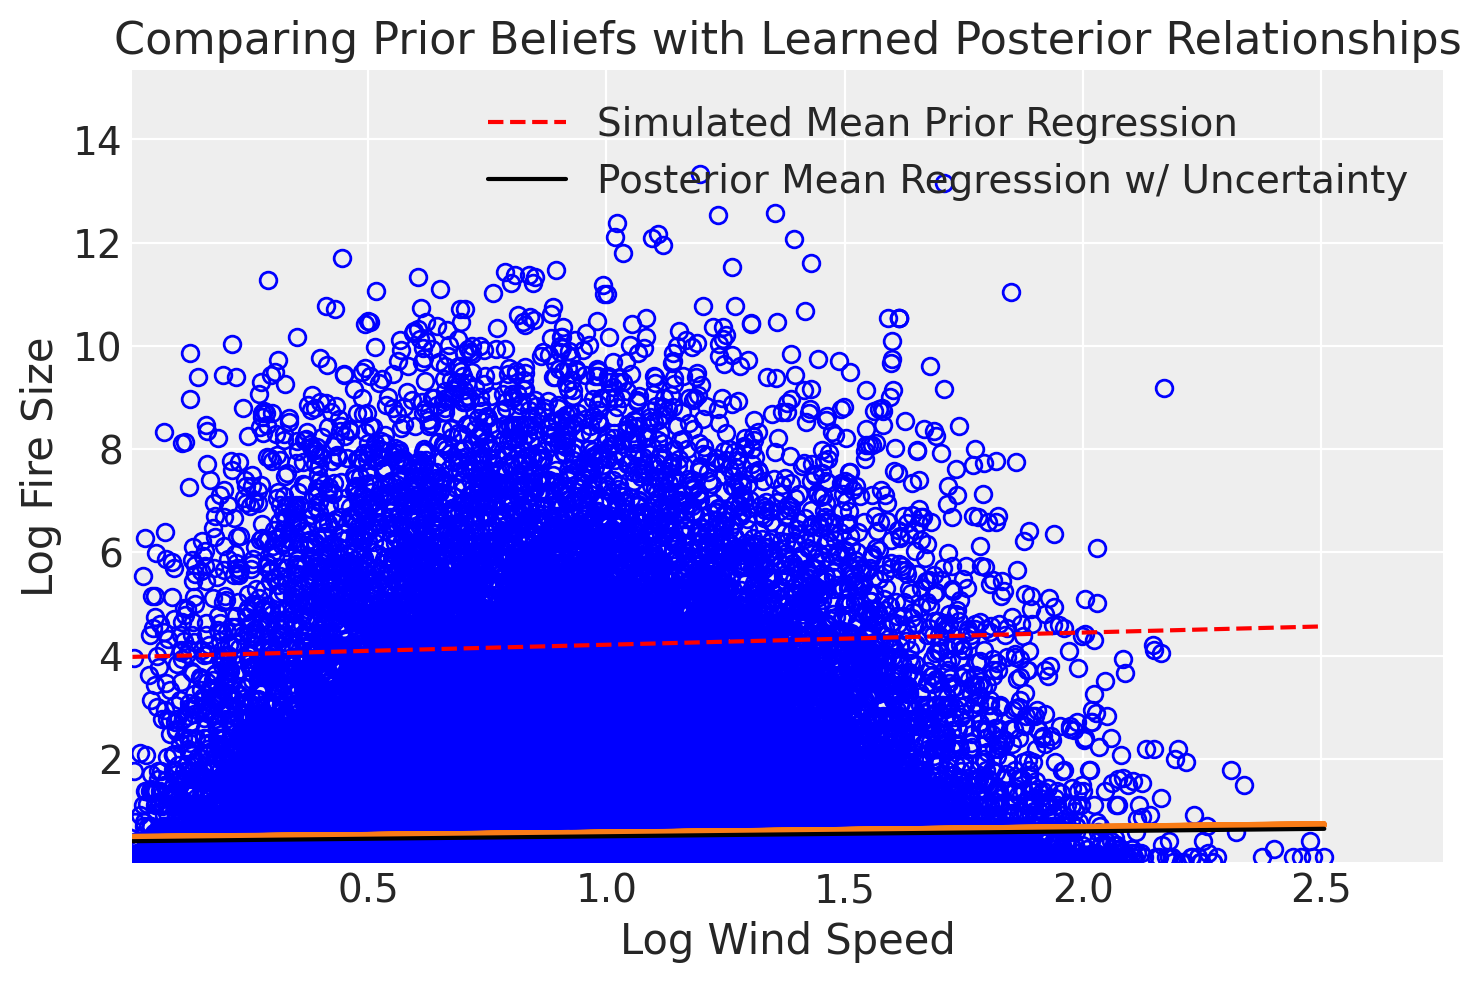

In [ ]:
# Plot of the uncertainty around the regression line including the original data

# 1. Plots the original scatter plot
posterior_dataset = az.extract_dataset(linear_reg_model_trace)
plt.plot(wind_speed_predictor, fire_size_target, marker="o", color="none", markeredgecolor="blue") # marker="o", color="none", markeredgecolor="C0")

# 2. Plots regression lines from each of the 20 values sampled in the a & b param.
nb_samples = posterior_dataset.sizes["sample"] #2000
idxs = rng.integers(nb_samples, size=100) # 100 random integers
for idx in idxs:
    plt.plot(
        wind_speed_predictor,
        posterior_dataset["a"].item(idx) + posterior_dataset["b"].item(idx) * wind_speed_predictor,
        "C1-",
        alpha=0.5,
    )

# 3. Plots mean prior predictive regression line
linear_reg_prior = []

for i in range(n_prior):
  regression = y_int_alpha.mean() + slope_beta.mean() * x_predictor[i]
  linear_reg_prior.append(regression)

plt.plot(x_predictor, linear_reg_prior, color='red', linestyle='--', label='Simulated Mean Prior Regression')

# 4. Plots mean posterior regression line
plt.plot(x_predictor, mu_mean, 'k', label='Posterior Mean Regression w/ Uncertainty')

# 5. Formats the rest of the graph.
plt.xlim(wind_speed_predictor.min(), wind_speed_predictor.max() + 0.25)
plt.ylim(fire_size_target.min(), fire_size_target.max() + 2)
plt.legend()
plt.ylabel("Log Fire Size")
plt.xlabel("Log Wind Speed")
plt.title("Comparing Prior Beliefs with Learned Posterior Relationships")
plt.show()

With the graph in front of us, there are a few key takeaways that we might not have observed with just the table alone. For one, given that the posterior regression line remained mostly flat, it’s clear that the model believes with high confidence that wind speed has minimal predictive power over fire size. In addition, the way in which the orange cloud of sampled posterior regression lines tightly and consistently hug its mean regression is a good indication that the model is confident in its assessment of a very weak relationship between these two variables.  And the fact that our dataset contained over 150,000 instances of wildfires in BC significantly reduced the model’s uncertainty since it had an ample amount of data to train on and update its prior beliefs. Given we didn’t necessarily get the results we wanted in terms of building a model with significant predictive power over the target variable, let’s discuss a few reasons as to why this was the case in the next section and what we can do better for next time.

## Next Steps

While the resulting posterior distributions seem to have produced reasonable parameter estimates *under the assumption that wind speed and fire size have a linear relationship to one another*, there are a few reasons to believe this is not actually the case. One of the key assumptions we need to make about our data when building a linear model is that the predictor and target variable must have a linear relationship to one another.

If we look back at the relationship between the scatterplot and regression line in the generic Simple Linear Regression model we generated in *Figure 1* as a reference, we can see that the individual scatterpoints “hug” the regression line to a certain extent. In a true linear relationship, data points cluster around the regression line in a consistent pattern. This ideal quality for regression models is referred to as **homoscedasticity**, which describes the constant spread of residual values along the predictor variable. **Residual values** just refer to the difference between predicted and actual values.

Unfortunately, the resulting graphs from *Figures 5* and *7* don’t display these qualities despite our attempts to normalize both variables through log transformations. Instead, we see a more of a cluster towards the bottom left-hand corner of the graph, signifying that the relationship between the two tends to be non-linear due to the higher propensity for small fires throughout the province. As a result of the seemingly non-linear relationship between our predictor and target variable, we’ve already violated one of the key assumptions of linearity in regression models.

In addition, we see evidence for the violation of another key assumption about the data when building linear regression models, which is heteroscedasticity, the opposite of homoscedasticity. We can see the evidence for **heteroscedasticity** again in *Figures 5* and *7*, where the variance of prediction errors increases at higher wind speeds rather than remaining constant. Additionally, our residuals are heavily skewed rather than normally distributed, which undermines the model's ability to predict extreme fire events - precisely the cases we most need to understand.

The root cause is clear: fire size follows a highly skewed distribution dominated by small fires, with occasional massive outliers. A simple linear relationship cannot capture this complexity, leaving our model poorly equipped to predict the large fires that matter most for wildfire management.

To summarise, the underlying faults of our model are largely due to the highly skewed distributions in our dataset and the seemingly non-linear relationship between the predictor and the target variable. Therefore, a simple linear relationship cannot capture this complexity, leaving our model poorly equipped to predict the large fires that matter most for wildfire management.

Having diagnosed some of the initial problems with our problem-framing, what could we do better for next time? One idea could be to add more variables and complexity by building a Multi-Linear Regression model. After all, the [wildfire dataset](https://github.com/vanislekahuna/wps-labs/tree/main/data/historical_bc_wildfires) we developed came packed with other predictor variables such as humidity levels and soil temperature. Perhaps we can also further engineer our underlying dataset to include even more features, such as topology or emergency response data, to further enrich our training data. We could have also applied techniques like polynomial regressions, which would have generated curvatures in our regression line so as to better model the nonlinear relationship of the variables. However, the risk of **overfitting** also increases where a model is too well-calibrated on the data it’s trained on and isn’t able to adapt well to new and unseen data. These are all concepts we will definitely explore in future articles!

While it would have been great to build a highly performant model in our initial foray into Bayesian Linear Regression, this was still a great learning opportunity, regardless, due to the firsthand experience we gained about the complexity of modelling dynamic systems. The real world isn’t as simple as textbooks or tutorials make it out to be, especially when it comes to applying statistical machine learning models and broadening human understanding. Besides, where would the fun be if there weren’t plot twists along the way and everything was just given to us? All this is part of the learning journey, and we’re glad you came along with us during this phase of expanding our knowledge on Bayesian Regression models.

Hope to see you in the next one 👊🏼

In [ ]:
y_mean_fire = np.mean(fire_size_target)
ss_tot_fire = np.sum((fire_size_target - y_mean_fire)**2)  # Total sum of squares
ss_res_prior_sim = np.sum((fire_size_target - linear_reg_prior)**2)  # Residual sum of squares
r_squared_manual_prior_sim_pred = 1 - (ss_res_prior_sim / ss_tot_fire)

print(f"The R-Squared value for the simulated mean prior regression line is {r_squared_manual_prior_sim_pred}")

The R-Squared value for the simulated mean prior regression line is -8.750227447278489


In [ ]:
y_mean_fire = np.mean(fire_size_target)
ss_tot_fire = np.sum((fire_size_target - y_mean_fire) ** 2)  # Total sum of squares
ss_res_posterior = np.sum((fire_size_target - mu_mean) ** 2)  # Residual sum of squares
r_squared_manual_posterior_pred = 1 - (ss_res_posterior / ss_tot_fire)

print(f"The R-Squared value for the mean posterior regression line is {r_squared_manual_posterior_pred}")

The R-Squared value for the mean posterior regression line is -0.004126801895677268
